#CMPE 258 HW3 - Part B1
Pytorch to build neural network of 3d input, 2d output

Abhishek Bais

In [1]:
# Import packages
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

# Generate 3d input, 2d output

In [2]:
# Generate 3-d input, 2d output
n = 100
d = 3
r1 = -1
r2 = 1
x = (r1 - r2) * torch.rand((n, d)) + r2

# y = 5x^2 + wx + b
weights_true = torch.tensor([[3., 2., -1.], [2., 3., 1.]]).T
bias_true = torch.tensor([[0.5], [0.5]]).T
print(x.shape, weights_true.shape, bias_true.shape)

y_true = torch.mm(5 * x ** 2, weights_true) + torch.mm(x, weights_true) + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

print('x is: ' + str(x[:2]))
print('y is: ' + str(y_true[:2]))

torch.Size([100, 3]) torch.Size([3, 2]) torch.Size([1, 2])
x: torch.Size([100, 3]), weights: torch.Size([3, 2]), bias: torch.Size([1, 2]), y: torch.Size([100, 2])
x is: tensor([[ 0.2400, -0.8498,  0.9576],
        [-0.7440, -0.2407, -0.1557]])
y is: tensor([[ 2.0643, 15.3822],
        [ 6.7032,  4.6598]])


# Generate a 3d TSNE plot of the data

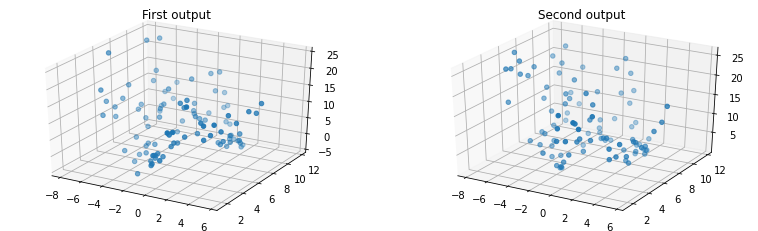

In [3]:
# Generate 3D TSNE plots for both outputs
def plot_3d(X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)
  fig = plt.figure(figsize=plt.figaspect(0.3))
  
  # plot the first output y[:,0]
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y[:,0], label='y_true')
  ax.set_title("First output")
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred[:,0], label='y_pred', marker='v')
  
  # plot the second output y[:,1]
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y[:,1], label='y_true')
  ax.set_title("Second output")
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred[:,1], label='y_pred', marker='v')
  
plot_3d(x, y_true)

# Define a loss function
MSE

In [4]:
# Loss Function with gradient descent
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true

  def loss(self):
    n = self.y_true.shape[0]
    return mean_squared_error(self.y_true, self.y_pred)

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2 * (self.y_pred - self.y_true) / n
    return self.gradient

# Define activation functions
Relu

In [5]:
# RELU non-linear layer class
class Relu:
  def __init__(self):
    self.input_ = torch.tensor([])

  def forward(self, input_):
    self.input_  = input_
    self.output_ = torch.clamp(self.input_, min=0)
    return self.output_
    
  def backward(self, out_gradient):
    self.input_gradient = (self.input_ > 0) * out_gradient
    return self.input_gradient
  
  def update(self, lr):
    return

# Define backpropagation for Linear, Relu layers

In [6]:
# Layer class with backpropagation 
# Default activation is linear, pass in activation='Relu' for non-linear
class Layer:
  # Init
  def __init__(self, ni=1, no=1, activation='Linear'):
    self.ni = ni
    self.no = no
    self.activation = 'Linear'

    # Init
    r1 = -1
    r2 = 1
    self.weights = (r1 - r2) * torch.rand(ni, no) + r2
    self.bias = torch.rand((1))
    self.x = torch.zeros((ni))
    
    # activation
    if activation == 'Relu':
      self.activation = Relu()
  
  # Forward propagate input, output
  def forward(self, x):
    self.x = x
    self.output = torch.mm(x, self.weights) + self.bias
    
    # Pass output to activation function
    if self.activation != 'Linear':
      return self.activation.forward(self.output)
    else:
      return self.output 
  
  # Backpropagate gradients
  def backward(self, upstream_gradient):
    gradient = upstream_gradient
    if self.activation != 'Linear':
      gradient = self.activation.backward(gradient)
    
    self.weights_gradient = torch.mm(torch.transpose(self.x,0,1), gradient)
    self.bias_gradient = gradient.sum()
    self.x_gradient = torch.mm(gradient, torch.transpose(self.weights,0,1))
    return self.x_gradient

  # Update weights, bias
  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient
  
  # Print the layer params
  def dump(self):
    print('Layer has ni', self.ni)
    print('Layer has no', self.no)
    print('Layer has activation function', self.activation)
    print('Layer has weights', self.weights)
    print('Layer has bias', self.bias)  

# Build the nueral net

In [7]:
# High level NN class
class Model:
  # Dump NN
  def dump(self):
    print('Builiding NN:')
    for j, layer in enumerate(self.layers):
      print('---- Layer {} ----'.format(j))
      layer.dump()

  # Init
  def __init__(self, ni=3, nh=[2], no=2, activation='Linear'):
    self.ni = ni
    self.nh = nh
    self.no = no
     
    # Build a chain of layers to form the NN
    self.layers = []
    self.layers.append(Layer(ni, no, activation='Linear'))
    self.layers.append(Layer(no, 5, activation))
    self.layers.append(Layer(5, 2, activation))
        
    # Dump the model created
    self.dump()
    
  # Forward propagate
  def forward(self, inputs):
    o = inputs
    for l in self.layers:
      o = l.forward(o)
    return o

  # Back propagate loss, gradients
  def backward(self, y_pred, y_true):
    mse = MSE(y_pred, y_true)
    print('Loss: ', mse.loss())
    loss_gradient = mse.backward()
    for layer in reversed(self.layers):
      loss_gradient = layer.backward(loss_gradient)

  # Update lr
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # Train model
  def fit(self, x, y_true, lr, epochs):
    print('Propagating input: ' + str(x[:2]))
    for epoch in range(epochs):
      y_pred = self.forward(x)
      self.backward(y_pred, y_true)
      self.update(lr)

# Train neural net with non-linear relu layer

In [8]:
# Configure hyperparams of model
num_epochs = 40
lr = 0.01
ni = x.shape[1]
no = y_true.shape[1]
nh = [5,3]

In [9]:
nn = Model(ni, nh, no=no, activation='Relu')
nn.fit(x, y_true, lr, num_epochs)
y_pred = nn.forward(x)

mse = MSE(y_true, y_pred)
print('Final Loss is ', mse.loss())

Builiding NN:
---- Layer 0 ----
Layer has ni 3
Layer has no 2
Layer has activation function Linear
Layer has weights tensor([[ 0.2570,  0.8190],
        [-0.8089,  0.6362],
        [ 0.9105,  0.9756]])
Layer has bias tensor([0.2190])
---- Layer 1 ----
Layer has ni 2
Layer has no 5
Layer has activation function <__main__.Relu object at 0x7f467d3cacd0>
Layer has weights tensor([[-0.4048, -0.8912, -0.2707,  0.6389, -0.7203],
        [-0.7085,  0.9040, -0.9670, -0.5477,  0.6178]])
Layer has bias tensor([0.0610])
---- Layer 2 ----
Layer has ni 5
Layer has no 2
Layer has activation function <__main__.Relu object at 0x7f467d3caa10>
Layer has weights tensor([[ 0.5401, -0.9868],
        [ 0.4375, -0.3457],
        [ 0.6419, -0.7982],
        [-0.9637, -0.7321],
        [-0.5169,  0.6556]])
Layer has bias tensor([0.8205])
Propagating input: tensor([[ 0.2400, -0.8498,  0.9576],
        [-0.7440, -0.2407, -0.1557]])
Loss:  108.353424
Loss:  102.28758
Loss:  96.244514
Loss:  89.84814
Loss:  82.6197

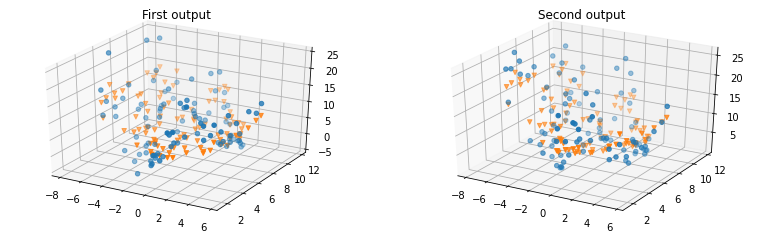

In [10]:
plot_3d(x, y_true, y_pred)

# Train neural net with only linear layers

In [11]:
nn = Model(ni, nh, no, activation='Linear')
nn.fit(x, y_true, lr, num_epochs)
y_pred = nn.forward(x)

mse = MSE(y_true, y_pred)
print('Final Loss is ', mse.loss())

Builiding NN:
---- Layer 0 ----
Layer has ni 3
Layer has no 2
Layer has activation function Linear
Layer has weights tensor([[ 0.2961, -0.4923],
        [-0.6354,  0.1929],
        [ 0.1997,  0.5535]])
Layer has bias tensor([0.6622])
---- Layer 1 ----
Layer has ni 2
Layer has no 5
Layer has activation function Linear
Layer has weights tensor([[-0.0130, -0.3841,  0.6862,  0.5766, -0.6799],
        [ 0.4350, -0.2501,  0.4332, -0.7451,  0.2517]])
Layer has bias tensor([0.5762])
---- Layer 2 ----
Layer has ni 5
Layer has no 2
Layer has activation function Linear
Layer has weights tensor([[ 0.0586,  0.9336],
        [-0.0742,  0.5773],
        [ 0.6543,  0.7299],
        [ 0.5050, -0.4579],
        [ 0.1281,  0.9527]])
Layer has bias tensor([0.2660])
Propagating input: tensor([[ 0.2400, -0.8498,  0.9576],
        [-0.7440, -0.2407, -0.1557]])
Loss:  89.65
Loss:  57.90152
Loss:  39.904915
Loss:  38.602203
Loss:  37.91748
Loss:  37.34072
Loss:  36.806778
Loss:  36.292885
Loss:  35.793144
Loss

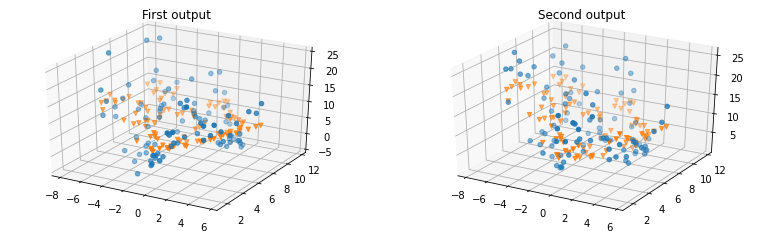

In [12]:
plot_3d(x, y_true, y_pred)